## Enssembling Machine Learning :

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import pickle
from datetime import datetime
import json

print("="*80)
print("ENSEMBLE MODEL TRAINING PIPELINE FOR CONSUMER COMPLAINTS")
print("="*80)

ENSEMBLE MODEL TRAINING PIPELINE FOR CONSUMER COMPLAINTS



# SECTION 1: CONFIGURATION AND DATA LOADING

In [9]:


import os
import gc
import pandas as pd
from sklearn.model_selection import train_test_split

print("\n[1] CONFIGURATION")
print("-"*80)

# Configuration
DATA_PATH = '/content/drive/MyDrive/consumer_complaints_classification_ready.xls'
LABEL_COLUMN = 'Label'
TEXT_COLUMN = 'Consumer complaint narrative'
SAMPLES_PER_CLASS = 50000
OUTPUT_DIR = '/content/drive/MyDrive/model_results/'
RANDOM_STATE = 42

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✓ Output directory: {OUTPUT_DIR}")

# Load data (actually CSV, despite .xls extension)
print(f"\n[2] LOADING DATA")
print("-"*80)
df = pd.read_csv(DATA_PATH)   # <-- FIXED: it's CSV, not Excel
print(f"✓ Original dataset shape: {df.shape}")
print(f"✓ Columns: {df.columns.tolist()}")

# Check if label column exists
if LABEL_COLUMN not in df.columns:
    print(f"\n⚠ '{LABEL_COLUMN}' column not found!")
    print(f"Available columns: {df.columns.tolist()}")
    raise ValueError(f"Column '{LABEL_COLUMN}' not found")

# Drop rows with missing complaint text
df = df.dropna(subset=[TEXT_COLUMN])

# Sample data: 50k from each class
print(f"\n[3] SAMPLING DATA ({SAMPLES_PER_CLASS:,} per class)")
print("-"*80)
df_sampled = df.groupby(LABEL_COLUMN).sample(
    n=SAMPLES_PER_CLASS, random_state=RANDOM_STATE, replace=True
)

# Shuffle
df_sampled = df_sampled.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"✓ Sampled dataset shape: {df_sampled.shape}")
print(f"\nClass distribution:")
print(df_sampled[LABEL_COLUMN].value_counts().sort_index())

# Prepare X and y
X = df_sampled[TEXT_COLUMN]
y = df_sampled[LABEL_COLUMN]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\n✓ Train size: {len(X_train):,}")
print(f"✓ Test size: {len(X_test):,}")

processed_path = os.path.join(OUTPUT_DIR, "consumer_complaints_sampled.csv")
df_sampled.to_csv(processed_path, index=False)
print(f"\n✓ Processed dataset saved at: {processed_path}")



[1] CONFIGURATION
--------------------------------------------------------------------------------
✓ Output directory: /content/drive/MyDrive/model_results/

[2] LOADING DATA
--------------------------------------------------------------------------------
✓ Original dataset shape: (2750824, 3)
✓ Columns: ['Consumer complaint narrative', 'Product', 'Label']

[3] SAMPLING DATA (50,000 per class)
--------------------------------------------------------------------------------
✓ Sampled dataset shape: (200000, 3)

Class distribution:
Label
0    50000
1    50000
2    50000
3    50000
Name: count, dtype: int64

✓ Train size: 160,000
✓ Test size: 40,000

✓ Processed dataset saved at: /content/drive/MyDrive/model_results/consumer_complaints_sampled.csv


In [11]:
df_sampled=pd.read_csv('/content/drive/MyDrive/model_results/consumer_complaints_sampled.csv')
df_sampled.head()

,Consumer complaint narrative,Product,Label
0,In XXXX of 2010 I purchased a Toyota. I did no...,Consumer Loan,2
1,On XX/XX/XXXX I called Concord and I spoke wit...,Debt collection,1
2,My mortgage servicer is Nationstar DBA Mr. Coo...,Mortgage,3
3,Back in XXXX I had a lawyer file with the cour...,Debt collection,1
4,I have received letters stating that they have...,"Credit reporting, credit repair services, or o...",0



# SECTION 2: TRAIN, TEST & VISUALIZATION USING XGBOOST

✓ Train size: 160,000
✓ Test size: 40,000

[1] Vectorizing text with TF-IDF...
✓ Vocabulary size: 5000

[2] Training XGBoost classifier...

[3] Model Evaluation
--------------------------------------------------------------------------------
Accuracy: 0.9022

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     10000
           1       0.86      0.85      0.85     10000
           2       0.90      0.93      0.92     10000
           3       0.97      0.94      0.95     10000

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



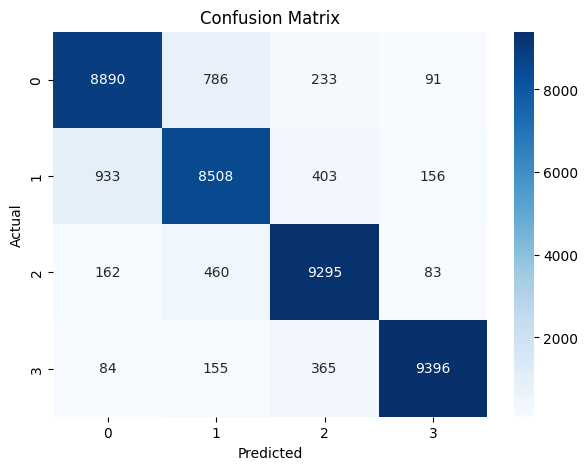

<Figure size 1000x600 with 0 Axes>

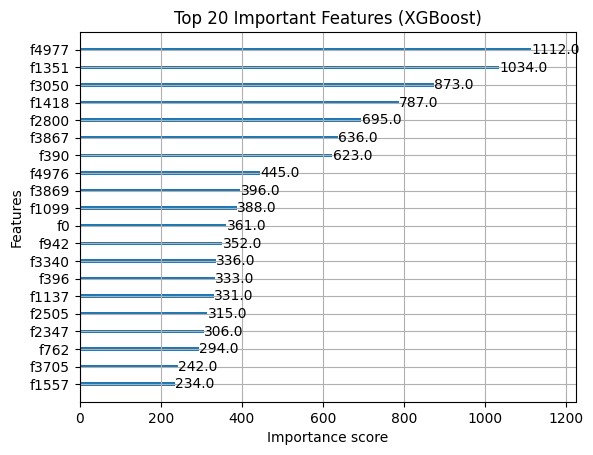

In [10]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier, plot_importance

# Load processed dataset
DATA_PATH = "/content/drive/MyDrive/model_results/consumer_complaints_sampled.csv"
df = pd.read_csv(DATA_PATH)

TEXT_COLUMN = 'Consumer complaint narrative'
LABEL_COLUMN = 'Label'
RANDOM_STATE = 42

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[TEXT_COLUMN], df[LABEL_COLUMN],
    test_size=0.2, random_state=RANDOM_STATE, stratify=df[LABEL_COLUMN]
)

print(f"✓ Train size: {len(X_train):,}")
print(f"✓ Test size: {len(X_test):,}")

# TF-IDF Vectorization
print("\n[1] Vectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✓ Vocabulary size: {len(vectorizer.get_feature_names_out())}")

# Train XGBoost
print("\n[2] Training XGBoost classifier...")
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb.fit(X_train_tfidf, y_train)

# Predictions
y_pred = xgb.predict(X_test_tfidf)

# Evaluation
print("\n[3] Model Evaluation")
print("-"*80)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df[LABEL_COLUMN].unique()),
            yticklabels=sorted(df[LABEL_COLUMN].unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# SECTION 3: TRAIN, TEST & VISUALIZATION USING LIGHTGBM CLASSIFIER

✓ Train size: 160,000
✓ Test size: 40,000

[1] Vectorizing text with TF-IDF...
✓ Vocabulary size: 5000

[2] Training LightGBM classifier...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 34.199190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787434
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 5000
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294

[3] Model Evaluation
--------------------------------------------------------------------------------
Accuracy: 0.9383

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91     10000
           1       0.91      0.

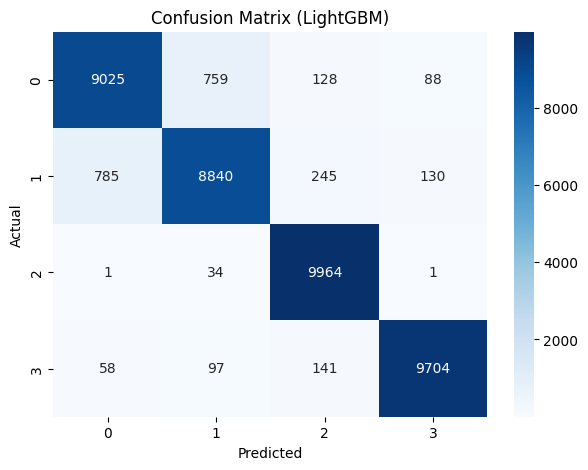

In [12]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# Load sampled dataset
df_sampled = pd.read_csv('/content/drive/MyDrive/model_results/consumer_complaints_sampled.csv')

TEXT_COLUMN = 'Consumer complaint narrative'
LABEL_COLUMN = 'Label'
RANDOM_STATE = 42

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_sampled[TEXT_COLUMN],
    df_sampled[LABEL_COLUMN],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=df_sampled[LABEL_COLUMN]
)

print(f"✓ Train size: {len(X_train):,}")
print(f"✓ Test size: {len(X_test):,}")

# Vectorize text with TF-IDF
print("\n[1] Vectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✓ Vocabulary size: {len(vectorizer.get_feature_names_out())}")

# Train LightGBM model
print("\n[2] Training LightGBM classifier...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    random_state=RANDOM_STATE,
    num_leaves=64
)

lgb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = lgb_model.predict(X_test_tfidf)

# Evaluation
print("\n[3] Model Evaluation")
print("-"*80)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df_sampled[LABEL_COLUMN].unique()),
            yticklabels=sorted(df_sampled[LABEL_COLUMN].unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LightGBM)")
plt.show()



# SECTION 4: TRAIN, TEST & VISUALIZATION USING CNN

Train shape: (160000, 5000)
Test shape: (40000, 5000)
0:	learn: 1.2454002	test: 1.2453650	best: 1.2453650 (0)	total: 623ms	remaining: 5m 10s
100:	learn: 0.4318592	test: 0.4408176	best: 0.4408176 (100)	total: 36.6s	remaining: 2m 24s
200:	learn: 0.3738831	test: 0.3860848	best: 0.3860848 (200)	total: 1m 5s	remaining: 1m 37s
300:	learn: 0.3446725	test: 0.3601670	best: 0.3601670 (300)	total: 1m 33s	remaining: 1m 1s
400:	learn: 0.3275157	test: 0.3454899	best: 0.3454899 (400)	total: 2m	remaining: 29.7s
499:	learn: 0.3143323	test: 0.3346604	best: 0.3346604 (499)	total: 2m 26s	remaining: 0us
bestTest = 0.3346604004
bestIteration = 499

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88     10000
           1       0.85      0.83      0.84     10000
           2       0.88      0.90      0.89     10000
           3       0.95      0.93      0.94     10000

    accuracy                           0.89     40000
   macro avg   

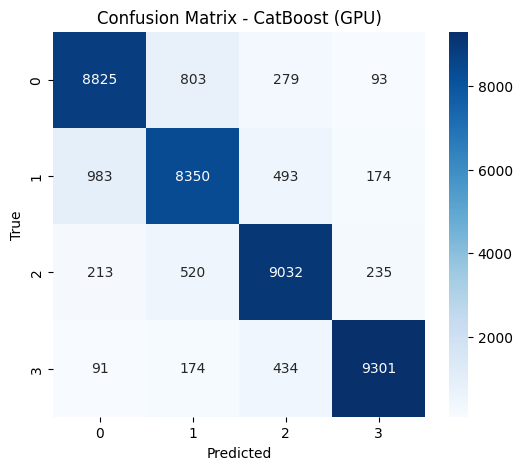

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df_sampled = pd.read_csv('/content/drive/MyDrive/model_results/consumer_complaints_sampled.csv')

# Features & Target
X = df_sampled["Consumer complaint narrative"].fillna("")
y = df_sampled["Label"]

# Text vectorization (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Convert into CatBoost Pool for GPU optimization
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Initialize CatBoost with GPU support
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    loss_function="MultiClass",
    task_type="GPU",      # ✅ Force CatBoost to use GPU
    devices='0',          # Use first GPU (change if multiple GPUs)
    verbose=100,
    random_seed=42
)

# Train model
model.fit(train_pool, eval_set=test_pool)

# Predictions
y_pred = model.predict(test_pool)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix - CatBoost (GPU)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [4]:
# Install dependencies
!pip install tensorflow -q

Num GPUs Available: 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.7511 - loss: 0.6435 - val_accuracy: 0.9025 - val_loss: 0.2837
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9013 - loss: 0.3015 - val_accuracy: 0.9140 - val_loss: 0.2521
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9199 - loss: 0.2409 - val_accuracy: 0.9211 - val_loss: 0.2352
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9290 - loss: 0.2103 - val_accuracy: 0.9239 - val_loss: 0.2298
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9369 - loss: 0.1850 - val_accuracy: 0.9233 - val_loss: 0.2358
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89     10000
           1       0.90      0.85      0.87     10000
           2       0.94      0.99      0.96     10000
           3       0.96      0.96      0.96     10000

    accura

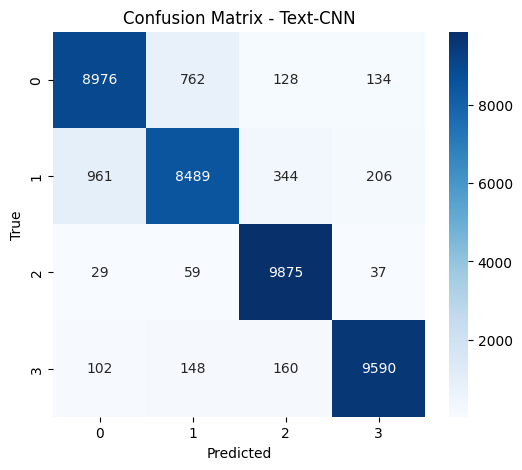

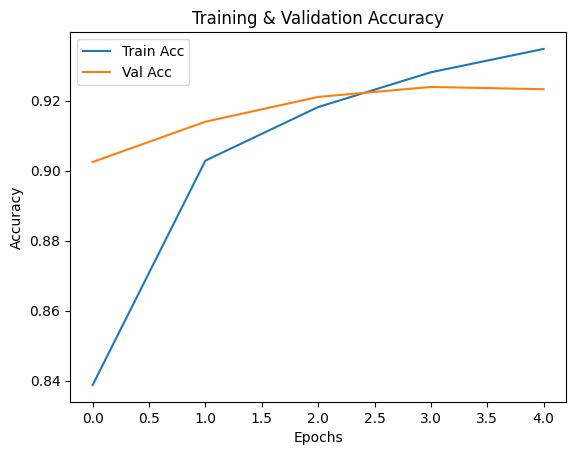

In [5]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/model_results/consumer_complaints_sampled.csv')

# Features and labels
texts = df["Consumer complaint narrative"].fillna("").astype(str).tolist()
labels = df["Label"]

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenization
MAX_WORDS = 20000  # Vocabulary size
MAX_LEN = 200      # Max sentence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

# Model: Text-CNN
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_LEN),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# Evaluate
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix - Text-CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Training history plot
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



# SECTION 5: TRAIN, TEST & VISUALIZATION USING LSTM/GRU

Num GPUs Available: 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 71s 26ms/step - accuracy: 0.7451 - loss: 0.6762 - val_accuracy: 0.8502 - val_loss: 0.4517
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - accuracy: 0.8731 - loss: 0.4054 - val_accuracy: 0.8997 - val_loss: 0.3095
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 64s 25ms/step - accuracy: 0.9115 - loss: 0.2929 - val_accuracy: 0.9049 - val_loss: 0.2971
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 64s 26ms/step - accuracy: 0.9243 - loss: 0.2421 - val_accuracy: 0.9129 - val_loss: 0.2680
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 64s 25ms/step - accuracy: 0.9373 - loss: 0.1990 - val_accuracy: 0.9187 - val_loss: 0.2585
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     10000
           1       0.87      0.86      0.87     10000
           2       0.94      0.97      0.96     10000
           3       0.96      0.95      0.96     10000

    a

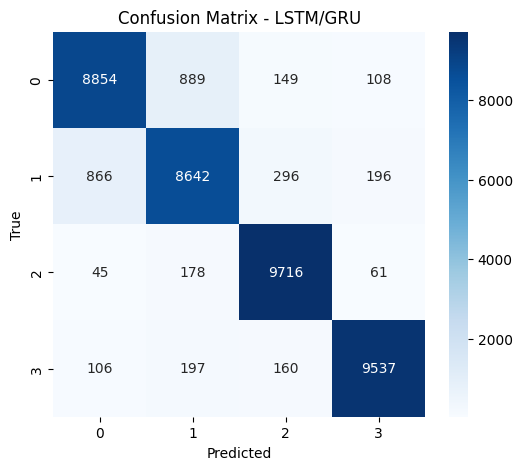

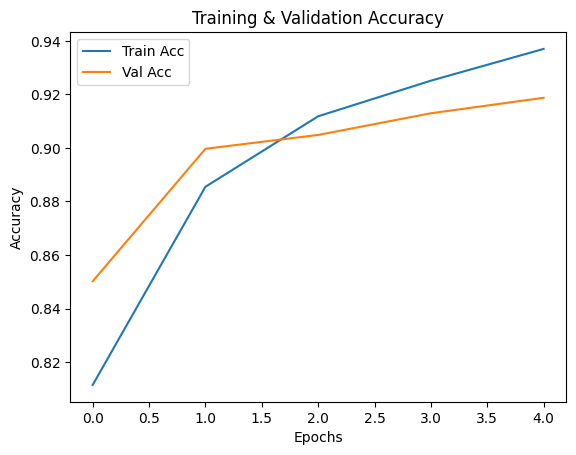

In [6]:
# ============================================================================
# TEXT CLASSIFICATION USING LSTM/GRU
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/model_results/consumer_complaints_sampled.csv')

# Features and labels
texts = df["Consumer complaint narrative"].fillna("").astype(str).tolist()
labels = df["Label"]

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenization
MAX_WORDS = 20000  # Vocabulary size
MAX_LEN = 200      # Maximum length of a complaint

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

# Build RNN model (LSTM/GRU)
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=False)),  # Can switch to GRU by using GRU(128)
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# Predictions
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix - LSTM/GRU")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Training history plot
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# SECTION 6: TRAIN, TEST & VISUALIZATION USING BiLSTM + Attention

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 256)            │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,840,332 (10.84 MB)

 Trainable params: 2,840,332 (10.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 74s 29ms/step - accuracy: 0.7712 - loss: 0.5845 - val_accuracy: 0.9023 - val_loss: 0.2888
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 70s 28ms/step - accuracy: 0.9095 - loss: 0.2770 - val_accuracy: 0.9079 - val_loss: 0.2672
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 70s 28ms/step - accuracy: 0.9252 - loss: 0.2264 - val_accuracy: 0.9176 - val_loss: 0.2495
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 71s 28ms/step - accuracy: 0.9392 - loss: 0.1826 - val_accuracy: 0.9216 - val_loss: 0.2515
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 71s 28ms/step - accuracy: 0.9475 - loss: 0.1539 - val_accuracy: 0.9215 - val_loss: 0.2588
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     10000
           1       0.88      0.86      0.87     10000
           2       0.93      0.99      0.96     10000
           3       0.96      0.96      0.96     10000

    a

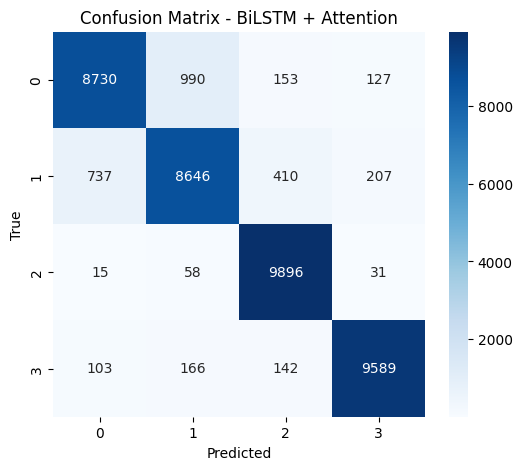

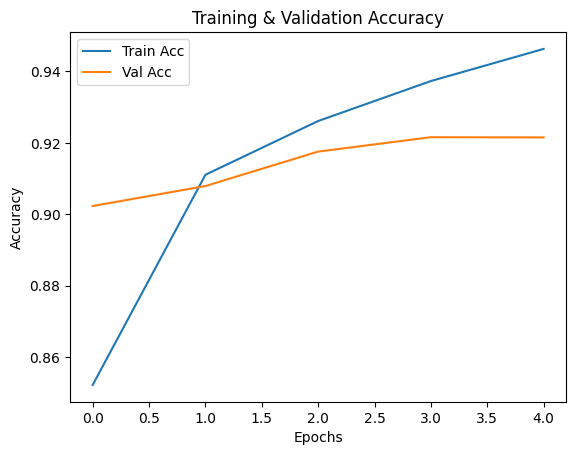

In [7]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
import tensorflow.keras.backend as K

# ============================
# Attention Layer Definition
# ============================
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# ============================
# Load dataset
# ============================
df = pd.read_csv('/content/drive/MyDrive/model_results/consumer_complaints_sampled.csv')
texts = df["Consumer complaint narrative"].fillna("").astype(str).tolist()
labels = df["Label"]

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenization
MAX_WORDS = 20000
MAX_LEN = 200
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

# ============================
# Build BiLSTM + Attention Model
# ============================
embedding_dim = 128
inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_LEN)(inputs)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Attention()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# ============================
# Train
# ============================
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# ============================
# Evaluate
# ============================
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix - BiLSTM + Attention")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================
# Plot Training Accuracy
# ============================
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
